In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import math
import random

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from ipywidgets import IntProgress
from IPython.display import display

**Adicionar fashion_mnist, horses_or_humans, mnist**

In [4]:
url_cat_dog = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
url_flower = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_cat = tf.keras.utils.get_file('cats_and_dogs.zip', origin=url_cat_dog, extract=True)
zip_flw = tf.keras.utils.get_file('flower_photos.tar', origin=url_flower, extract=True)

path_cat = os.path.join(os.path.dirname(zip_cat), 'cats_and_dogs_filtered')
path_flw = os.path.join(os.path.dirname(zip_flw), 'flower_photos')

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

In [6]:
train_cat = tf.keras.utils.image_dataset_from_directory(os.path.join(path_cat, 'train'), shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
valid_cat = tf.keras.utils.image_dataset_from_directory(os.path.join(path_cat, 'validation'), shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

train_flw = tf.keras.utils.image_dataset_from_directory(path_flw, validation_split=0.2, subset="training", seed=123, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
valid_flw = tf.keras.utils.image_dataset_from_directory(path_flw, validation_split=0.2, subset="validation", seed=123, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
cat_class_names = train_cat.class_names
flw_class_names = train_flw.class_names

# Viz

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_cat.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(cat_class_names[labels[i]])
        plt.axis("off")

plt.show()

plt.figure(figsize=(10, 10))
for images, labels in train_flw.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(flw_class_names[labels[i]])
        plt.axis("off")

# Preprocessing

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

cat_train_ds = train_cat.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
cat_valid_ds = valid_cat.cache().prefetch(buffer_size=AUTOTUNE)

flw_train_ds = train_flw.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
flw_valid_ds = valid_flw.cache().prefetch(buffer_size=AUTOTUNE)

# Model

In [9]:
def generate_model(num_classes):
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
      ])
    return Sequential([
        data_augmentation,
        layers.Rescaling(1./255),
        layers.Conv2D(16, 3, padding='same', activation='relu'),#, kernel_regularizer=regularizer()),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
    ])

In [10]:
def print_performance(title, history, epochs=None):
    val_acc = None
    val_loss = None
    
    if 'history' in history:
        acc = history.history['accuracy']
        loss = history.history['loss']
        val_acc = history.history['val_accuracy']
        val_loss = history.history['val_loss']
    else:
        acc = history['accuracy']
        loss = history['loss']
        if 'val_accuracy' in history:
            val_acc = history['val_accuracy']
            val_loss = history['val_loss']
            
    if epochs is None:
        epochs = len(loss)
    
    print(title, 'acc:', acc[-1], 'val_acc:', 'None' if val_acc is None else val_acc[-1])

    epochs_range = range(epochs)

    plt.figure(figsize=(15, 5))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    if val_acc is not None:
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    if val_loss is not None:
        plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def print_filters_1d(filters):
    depth = filters.shape[-1]
    size = math.ceil(math.sqrt(depth))
    
    if depth < (size*size):
        filters = np.resize(filters, (size*size))
    
    fig, axarr = plt.subplots(1,1, figsize=(size/4, size/4))
    axarr.axis('off')
    axarr.imshow(np.reshape(filters, (size, size)))
    fig.suptitle(filters.shape, fontsize=8)

def print_filters_2d(filters):
    depth = filters.shape[-1]
    mj = filters.shape[-2]
    mi = math.ceil(depth/mj)
    fi = 0
    fig, axarr = plt.subplots(mi, mj, figsize=(20, mi))
    for i in range(mi):
        for j in range(mj):
            axarr[i][j].axis('off')
            if fi < depth:
                axarr[i][j].imshow(filters[:,:,fi,0], cmap='gray')
            fi += 1
    fig.suptitle(filters.shape, fontsize=8)
    
def print_filters_3d(filters):
    depth = filters.shape[-1]
    mj = 16
    mi = math.ceil(depth/mj)
    fi = 0
    fig, axarr = plt.subplots(mi, mj, figsize=(20, mi))
    if mi == 1:
        for j in range(mj):
            axarr[j].axis('off')
            if fi < depth:
                axarr[j].imshow(filters[:,:,fi])
            fi += 1
    else:
        for i in range(mi):
            for j in range(mj):
                axarr[i][j].axis('off')
                if fi < depth:
                    axarr[i][j].imshow(filters[:,:,fi])
                fi += 1
    fig.suptitle(filters.shape, fontsize=8)

In [11]:
def custom_evaluate(model, loss, ds_validation):
    loss_avg = tf.keras.metrics.Mean()
    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        
    for x, y in ds_validation:
        logits = model(x, training=False)
        loss_value = loss(y, logits)
        
        loss_avg.update_state(loss_value)
        accuracy.update_state(y, logits)
        
    return loss_avg.result().numpy(), accuracy.result().numpy()
                
def custom_training(model, optimizer, loss, ds_train, num_epochs):
    #global global_grads
    train_loss_results = []
    train_accuracy_results = []
    
    f = IntProgress(min=0, max=num_epochs)
    display(f)
    
    for epoch in range(num_epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

        for x, y in ds_train:
            with tf.GradientTape() as tape:
                logits = model(x, training=True)
                loss_value = loss(y, logits)
            
            grads = tape.gradient(loss_value, model.trainable_weights)
            #global_grads = grads
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            #raise 'hehehehe'
            
            epoch_loss_avg.update_state(loss_value)
            epoch_accuracy.update_state(y, logits)
        
        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())
        
        f.value += 1

    return {'loss': train_loss_results, 'accuracy': train_accuracy_results}

In [12]:
def get_threshold_activation(model, dataset, neuron_layers):
    #activations = {'cnn':[], 'dnn':[]}
    activations = {}
    #maxes = {}
    #mines = {}
    means = {}
    for l in neuron_layers:
        activations[l] = None
        #maxes[l] = None
        #mines[l] = None
        means[l] = 0
    
    f = IntProgress(min=0, max=len(dataset))
    display(f)
    
    ds_size = 0
    cnn_max = None
    dnn_max = None
    
    for images, labels in dataset:
        for i in range(1, len(images)+1):
            out = images[i-1:i]
            ds_size += 1
            for l in range(len(model.layers)):
                out = model.layers[l](out)
                if l in neuron_layers:
                    
                    if len(out[0].shape) > 1: # cnn
                        #maxi = np.max(out[0], axis=(0,1))
                        #mini = np.min(out[0], axis=(0,1))
                        non_zero = []
                        for fil in range(out[0].shape[2]):
                            non_zero.append(np.mean(out[0][:,:,fil][out[0][:,:,fil] > 0]))
                        meani = np.mean(non_zero)
                    else:
                        #maxi = out[0].numpy()
                        #mini = out[0].numpy()
                        non_zero = out[0][out[0] > 0]
                        meani = np.mean(non_zero)
                        
                    means[l] += meani
                    continue
                        
                    if maxes[l] is None:
                        maxes[l] = maxi.copy()
                    else:
                        maxes[l] = np.max([maxes[l], maxi], axis=(0))
                        
        f.value += 1
        
    print(means)
    #mean_per_layer = {}
    for l in neuron_layers:
        #no_zero_max = maxes[l][maxes[l] > 0]
        #mean_per_layer[l] = np.mean(maxes[l])
        means[l] = means[l] / ds_size
        
    return means
        
    f = IntProgress(min=0, max=len(dataset))
    display(f)
    
    for images, labels in dataset:
        for i in range(1, len(images)+1):
            out = images[i-1:i]
            ds_size += 1
            for l in range(len(model.layers)):
                out = model.layers[l](out)
                if l in neuron_layers:
                    neurons_actv = None
                    neurons_med = None
                    if len(out[0].shape) > 1: # cnn
                        #neurons_actv = np.sum(out[0], axis=(0,1))
                        #neurons_med = np.mean(out[0], axis=(0,1))
                        #neurons_std = np.std(out[0], axis=(0,1))
                        #neurons_actv = np.count_nonzero(out[0] > neurons_med, axis=(0,1))
                        neurons_actv = np.count_nonzero((out[0]/cnn_max) > 0.5, axis=(0,1))
                        #neurons_actv = np.sum(out[0].numpy()/dnn_max, axis=(0,1))
                        
                        #print(neurons_med)
                        #print(neurons_actv)
                        #for p in range(3):
                        #    print(out[0][:,:,p].shape, neurons_med[p])
                        #    print(np.count_nonzero(out[0][:,:,p] > neurons_med[p], axis=(0,1)))
                        #print_filters_3d(out[0])
                        #raise 'aaa'
                    else: # dnn
                        neurons_actv = out[0].numpy()/dnn_max
                        
                    if activations[l] is None:
                        activations[l] = neurons_actv
                    else:
                        activations[l] += neurons_actv
                    
                    #for n in range(len(neurons_actv)):
                        #key = 'cnn' if len(out[0].shape) > 1 else 'dnn'
                        #activations[key].append(neurons_actv[n])
                        #if n not in activations[l]:
                        #    activations[l][n] = []
                            #activations[l][str(n)+'_val'] = []
                        #activations[l][n].append(neurons_actv[n])
                        #if neurons_med is not None:
                        #    activations[l][str(n)+'_val'].append(neurons_med[n])
        f.value += 1
    
    print('ds_size', ds_size, 'len(dataset)', len(dataset))
    
    activations2 = {}
    for layer in activations:
        #array_activations = []
        #for neuron in activations[layer]:
        #    array_activations.append(np.mean(activations[layer][neuron]))
            
        activations2[layer] = activations[layer] / ds_size
        
    scales = {
        'cnn_max':cnn_max,
        'dnn_max':dnn_max
    }
    
    return activations2, activations, scales

def get_activation_frequency(model, dataset, neuron_layers, thresholds):
    activations = {}
    for l in neuron_layers:
        activations[l] = None
    
    f = IntProgress(min=0, max=len(dataset))
    display(f)
    
    ds_size = 0
    
    for images, labels in dataset:
        for i in range(1, len(images)+1):
            out = images[i-1:i]
            ds_size += 1
            for l in range(len(model.layers)):
                out = model.layers[l](out)
                if l in neuron_layers:
                    
                    if len(out[0].shape) > 1: # cnn
                        a = np.sum(out[0].numpy(), axis=(0,1))
                    else: # dnn
                        a = out[0].numpy().copy()
                        
                    a[a <= thresholds[l]] = 0.0
                    a[a > thresholds[l]] = 1.0
                    
                    if activations[l] is None:
                        activations[l] = a
                    else:
                        activations[l] += a
                    
                    #for n in range(len(a)):
                    #    if n not in activations[l]:
                    #        activations[l][n] = 0
                    #    activations[l][n] += a[n]
        f.value += 1
    print('ds_size', ds_size, 'len(dataset)', len(dataset))
    activations2 = {}
    for layer in activations:
        activations2[layer] = activations[layer] / ds_size
        
    return activations2, activations

def get_mean_input(model, dataset, first_layer):
    means = None
    deviations = None
    
    f = IntProgress(min=0, max=len(dataset))
    display(f)
    
    for images, labels in dataset:
        for i in range(1, len(images)+1):
            out = images[i-1:i]
            for l in range(len(model.layers)):
                if l == first_layer:
                    break
                out = model.layers[l](out)
                
            if means is None:
                means = np.copy(out)
            else:
                means += out
                    
        f.value += 1

    means = means / len(dataset)
    print('Mean calculated')
    
    f = IntProgress(min=0, max=len(dataset))
    display(f)
    
    for images, labels in dataset:
        for i in range(1, len(images)+1):
            out = images[i-1:i]
            for l in range(len(model.layers)):
                if l == first_layer:
                    break
                out = model.layers[l](out)
                
            if deviations is None:
                deviations = (out - means)**2
            else:
                deviations += (out - means)**2
                
        f.value += 1
    
    deviations = np.sqrt(deviations / len(dataset))
    print('Std dev calculated')
    
    return means, deviations

def get_mean_output(model, dataset, neuron_layers):
    means = {}
    deviations = {}
    for l in neuron_layers:
        means[l] = None
        deviations[l] = None
    
    f = IntProgress(min=0, max=len(dataset))
    display(f)
    
    for images, labels in dataset:
        for i in range(1, len(images)+1):
            out = images[i-1:i]
            for l in range(len(model.layers)):
                out = model.layers[l](out)
                if l in neuron_layers:
                    if means[l] is None:
                        means[l] = np.copy(out)
                    else:
                        means[l] += out
        f.value += 1

    for l in neuron_layers:
        means[l] = means[l] / len(dataset)
    print('Mean calculated')
        
    #f = IntProgress(min=0, max=len(dataset))
    #display(f)
    
    #for images, labels in dataset:
    #    for i in range(1, len(images)+1):
    #        out = images[i-1:i]
    #        for l in range(len(model.layers)):
    #            out = model.layers[l](out)
    #            if l in neuron_layers:
    #                if deviations[l] is None:
    #                    deviations[l] = (out - means[l])**2
    #                else:
    #                    deviations[l] += (out - means[l])**2
    #    f.value += 1
    
    #for l in neuron_layers:
    #    deviations[l] = np.sqrt(deviations[l] / len(dataset))
    #print('Std dev calculated')
    
    return means, deviations

# Training T1, T2

In [ ]:
%%time
epochs=10
model = generate_model(len(flw_class_names))
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt1 = model.fit(train_flw, validation_data=valid_flw, epochs=epochs, verbose=0)
print_performance('T1', historyt1, epochs)

In [ ]:
%%time
epochs=10
model = generate_model(len(cat_class_names))
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt2 = model.fit(train_cat, validation_data=valid_cat, epochs=epochs, verbose=0)
print_performance('T2', historyt1, epochs)

# Join datasets Y

In [13]:
total_label = len(flw_class_names) + len(cat_class_names)
diff_flw = total_label - len(flw_class_names)
diff_cat = total_label - len(cat_class_names)

In [14]:
train_cat_join = train_cat.map(lambda x, y: (x, y + diff_cat))
valid_cat_join = valid_cat.map(lambda x, y: (x, y + diff_cat))

In [15]:
train_flw_and_cat = train_flw.concatenate(train_cat_join).shuffle(32)
valid_flw_and_cat = valid_flw.concatenate(valid_cat_join).shuffle(32)

# Training T1 -> T2

In [ ]:
%%time
epochs=10
model = generate_model(total_label)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt1 = model.fit(train_flw, validation_data=valid_flw, epochs=epochs, verbose=0)
print_performance('T1', historyt1, epochs)

In [ ]:
%%time

losst1, acct1 = model.evaluate(valid_flw)
losst2, acct2 = model.evaluate(valid_cat_join)
print('Pre Train:')
print('T1', 'acc:', acct1, 'loss:', losst1)
print('T2', 'acc:', acct2, 'loss:', losst2)

epochs=10
historyt2 = model.fit(train_cat_join, validation_data=valid_cat_join, epochs=epochs, verbose=0)

losst1, acct1 = model.evaluate(valid_flw)
print('Post Train:')
print('T1', 'acc:', acct1, 'loss:', losst1)

print_performance('T2', historyt2, epochs)

# Layer types

In [16]:
cnn_layers = [2,4,6]
neuron_layers = [10,11]
all_layers = [2,4,6,10,11]

# Threshold tests

In [16]:
%%time
epochs=10
model = generate_model(total_label)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt1 = model.fit(train_flw, validation_data=valid_flw, epochs=epochs, verbose=0)

CPU times: total: 13min 1s
Wall time: 3min 53s


In [17]:
%%time
epochs=10
model2 = generate_model(total_label)
model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt2 = model2.fit(train_cat_join, validation_data=valid_cat_join, epochs=epochs, verbose=0)

CPU times: total: 9min 15s
Wall time: 2min 38s


In [18]:
%%time
epochs=10
model3 = generate_model(total_label)
model3.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt3 = model3.fit(train_flw, validation_data=valid_flw, epochs=epochs, verbose=0)
historyt32 = model3.fit(train_cat_join, validation_data=valid_cat_join, epochs=epochs, verbose=0)

CPU times: total: 22min 10s
Wall time: 6min 21s


In [28]:
meanst1, deviationst1 = get_mean_output(model, train_flw, neuron_layers)

IntProgress(value=0, max=92)

Mean calculated


IntProgress(value=0, max=92)

Std dev calculated


In [20]:
meanst2, deviationst2 = get_mean_output(model2, train_cat_join, neuron_layers)

IntProgress(value=0, max=63)

Mean calculated


IntProgress(value=0, max=63)

Std dev calculated


In [21]:
meanst31, deviationst31 = get_mean_output(model3, train_flw, neuron_layers)
meanst32, deviationst32 = get_mean_output(model3, train_cat_join, neuron_layers)

IntProgress(value=0, max=92)

Mean calculated


IntProgress(value=0, max=92)

Std dev calculated


IntProgress(value=0, max=63)

Mean calculated


IntProgress(value=0, max=63)

Std dev calculated


In [19]:
meanst1all, _ = get_mean_output(model, train_flw, all_layers)
meanst2all, _ = get_mean_output(model2, train_cat_join, all_layers)

IntProgress(value=0, max=92)

Mean calculated


IntProgress(value=0, max=92)

Std dev calculated


IntProgress(value=0, max=63)

Mean calculated


IntProgress(value=0, max=63)

Std dev calculated


# Viz activation and weigths

(3, 3, 3, 16)
(3, 3, 16, 32)
(3, 3, 32, 64)
(3, 3, 16, 32)
[[-0.10759593 -0.05584408  0.04740174]
 [ 0.04524972 -0.10287233  0.00275661]
 [ 0.06386237  0.03487718 -0.015535  ]]
[[ 3.7684415e-03  1.9558838e-03 -1.6601994e-03]
 [-1.5848270e-03  3.6030018e-03 -9.6547657e-05]
 [-2.2367164e-03 -1.2215389e-03  5.4409803e-04]]


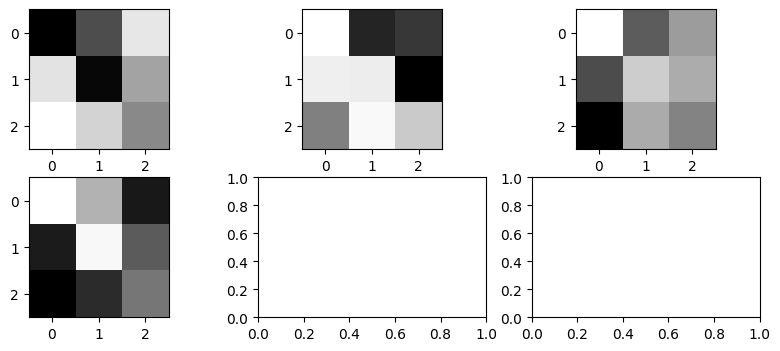

In [25]:
print(model.layers[2].get_weights()[0].shape)
print(model.layers[4].get_weights()[0].shape)
print(model.layers[6].get_weights()[0].shape)

lay = 4

percented = (model.layers[lay].get_weights()[0] / model.layers[lay].get_weights()[0].sum())
print(percented.shape)

print(model.layers[lay].get_weights()[0][:,:,0,0])
print(percented[:,:,0,0])

fig, axarr = plt.subplots(2, 3, figsize=(10, 4))
axarr[0,0].imshow(model.layers[lay].get_weights()[0][:,:,0,0], cmap='gray')
axarr[0,1].imshow(model.layers[lay].get_weights()[0][:,:,1,0], cmap='gray')
axarr[0,2].imshow(model.layers[lay].get_weights()[0][:,:,2,0], cmap='gray')
axarr[1,0].imshow(percented[:,:,0,0], cmap='gray')

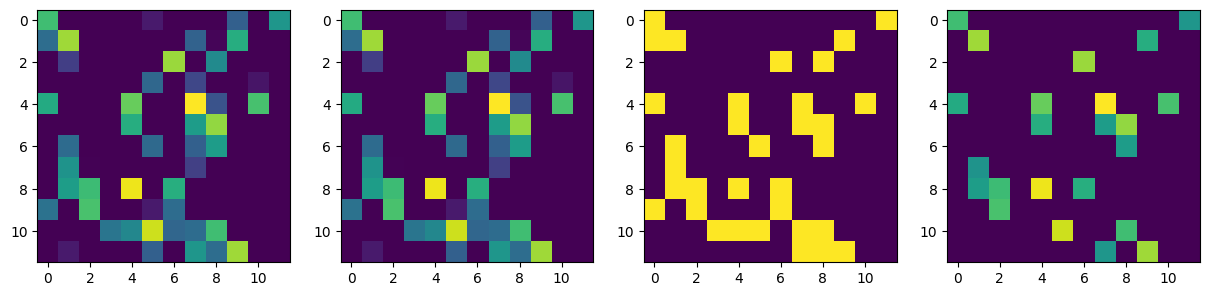

In [61]:
th = 26.29
thpercent = 0.5

mmat = np.reshape(np.resize(meanst1all[10][0], (144)), (12, 12))

percented = (meanst1all[10][0].numpy() / meanst1all[10][0].numpy().max()) # sum
mmat2 = np.reshape(np.resize(percented, (144)), (12, 12))

mmat3 = mmat.copy()
mmat3[mmat <= th] = 0
mmat3[mmat > th] = 1

mmat4 = mmat2.copy()
mmat4[mmat2 <= thpercent] = 0
#mmat4[mmat2 > thpercent] = 1

mmat5 = mmat2.copy()
mmat5[mmat2 <= thpercent] = 0

fig, axarr = plt.subplots(1, 4, figsize=(15, 5))
axarr[0].imshow(mmat)
axarr[1].imshow(mmat2)
axarr[2].imshow(mmat3)
axarr[3].imshow(mmat4)
axarr[3].imshow(mmat5)

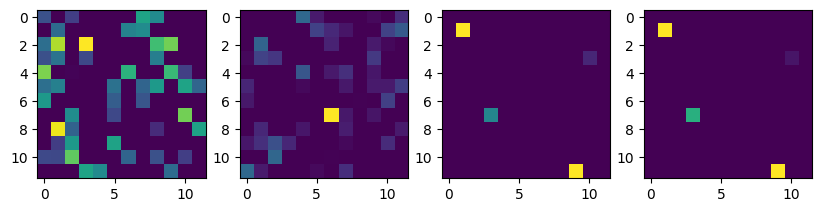

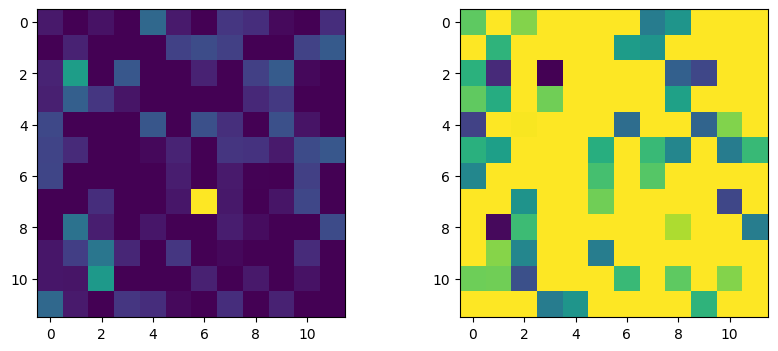

In [24]:
fig, axarr = plt.subplots(1, 4, figsize=(10, 4))
mat1 = np.reshape(np.resize(meanst1[10][0], (144)), (12, 12))
mat2 = np.reshape(np.resize(meanst2[10][0], (144)), (12, 12))
mat3 = np.reshape(np.resize(meanst31[10][0], (144)), (12, 12))
mat4 = np.reshape(np.resize(meanst32[10][0], (144)), (12, 12))
axarr[0].imshow(mat1)
axarr[1].imshow(mat2)
axarr[2].imshow(mat3)
axarr[3].imshow(mat4)
plt.show()

diff_u = mat1 + mat2
diff_mat2 = mat1 * -1
#multpld_mat = np.multiply(mat2, diff_mat)
fig, axarr = plt.subplots(1, 2, figsize=(10, 4))
axarr[0].imshow(diff_u)
axarr[1].imshow(diff_mat2)
plt.show()

In [38]:
meanst1all[2][0].shape

TensorShape([128, 128, 16])

In [77]:
per_filter_index = tot > med
mem_index = np.array([filter_index * 1.0 for filter_index in per_filter_index])
#mem_index = np.reshape(mem_index, (3,3,3,16))

In [87]:
tot

array([3.6203262e+03, 2.6822229e+04, 6.4217121e+04, 1.0602372e+04,
       1.2052476e+04, 1.6861554e+03, 7.2256664e+04, 2.7287377e+04,
       4.1265439e-02, 2.4190247e+03, 2.4805602e+04, 8.9495172e+04,
       3.1686577e+03, 5.4692883e+04, 1.0920461e+04, 1.8925664e+03],
      dtype=float32)

In [88]:
1 - pct

array([0.9595472 , 0.70029414, 0.28245157, 0.88153136, 0.8653282 ,
       0.98115927, 0.19261944, 0.6950967 , 0.9999995 , 0.9729703 ,
       0.7228275 , 0.        , 0.96459407, 0.3888734 , 0.8779771 ,
       0.97885287], dtype=float32)

In [72]:
arr = meanst1all[2][0].numpy()
tot = arr.reshape(-1, arr.shape[-1]).sum(axis=0)
pct = (tot / tot.max())
med = np.percentile(tot, 50)
print(tot > med)
print(pct > 0.5)

[False  True  True False  True False  True  True False False  True  True
 False  True False False]
[False False  True False False False  True False False False False  True
 False  True False False]


In [ ]:
for l in cnn_layers:
	print_filters_2d(model.layers[l].get_weights()[0])

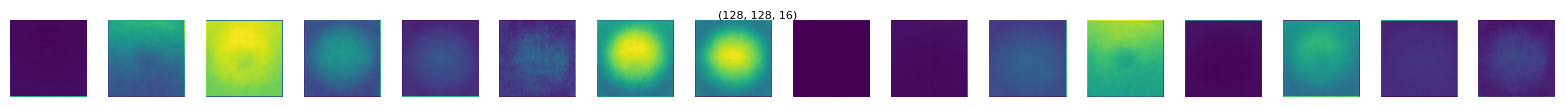

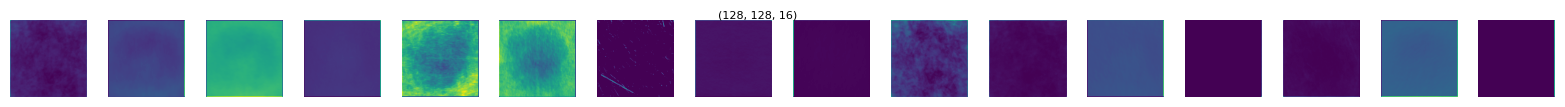

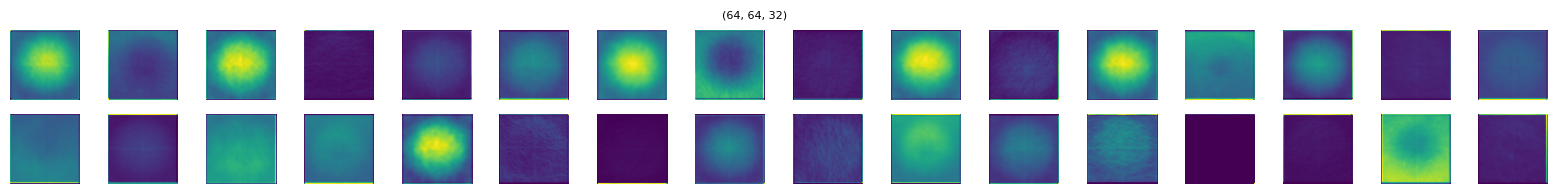

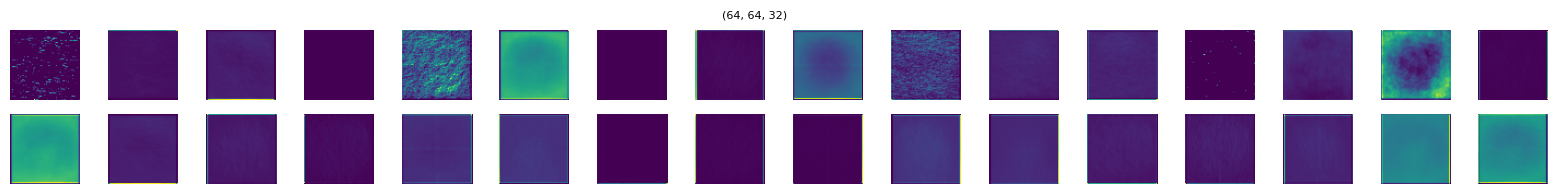

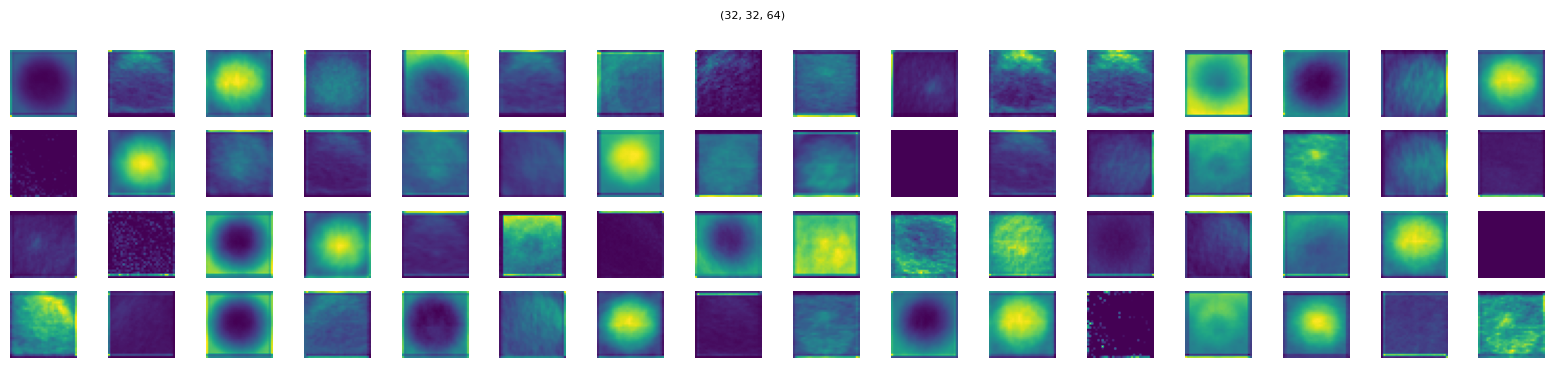

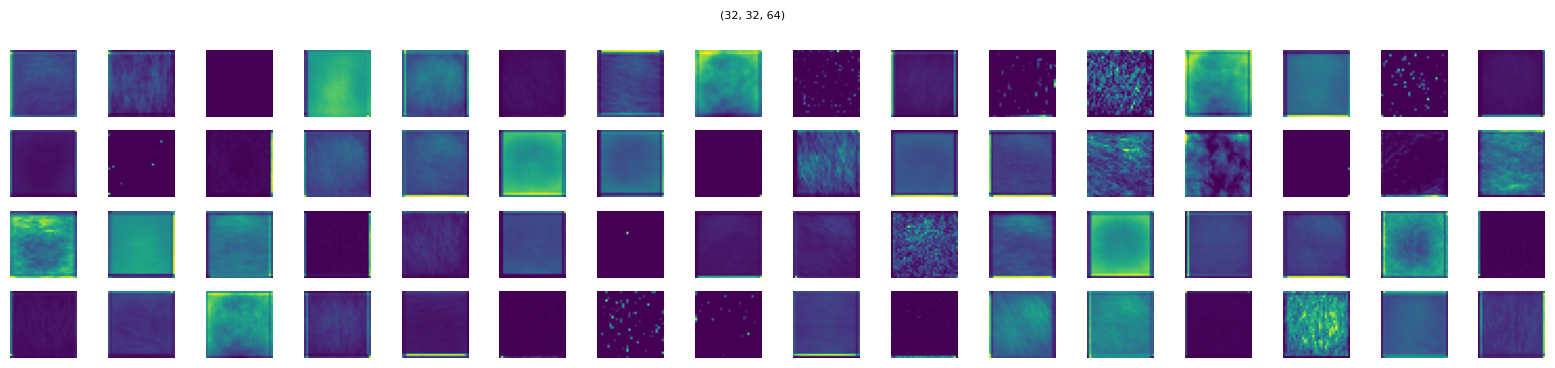

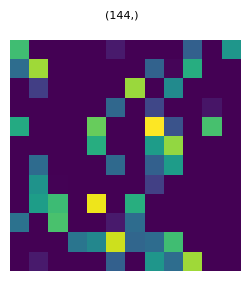

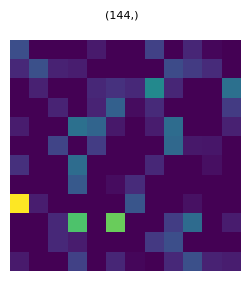

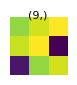

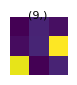

In [71]:
for l in all_layers:
    ftrs = meanst1all[l][0]
    ftrs2 = meanst2all[l][0]
    
    if len(ftrs.shape) == 1:
        print_filters_1d(ftrs)
        print_filters_1d(ftrs2)
    elif len(ftrs.shape) == 3:
        print_filters_3d(ftrs)
        print_filters_3d(ftrs2)

# Sleep

In [17]:
def one_pass(model, ds_reminder, thresholds):
    for x, y in ds_reminder:
        for i in range(1, len(x)+1):
            out = x[i-1:i]
            activations = []
            outs = [out]

            # forward
            for l in range(len(model.layers)):
                out = model.layers[l](out)
                if len(model.layers[l].get_weights()) > 0:
                    outs.append(out)
                    #print(out.shape)
                    if len(out.shape) > 2: # cnn
                        a = np.sum(out, axis=(0,1,2))
                        #neurons_med = np.mean(out, axis=(0,1,2))
                        #a = np.count_nonzero(out > neurons_med, axis=(0,1,2))
                    else: # dnn
                        a = out.numpy()[0].copy()
                    a[a <= thresholds[l]] = 0.0
                    a[a > thresholds[l]] = 1.0
                    activations.append(a)
            break
        break

    return activations, outs

def custom_sleep(model, ds_reminder, thresholds, epochs=30, inc=0.01, dec=0.001):
    f = IntProgress(min=0, max=epochs)
    display(f)
    
    for epoch in range(epochs):
        for x, y in ds_reminder:
            for i in range(1, len(x)+1):
                out = x[i-1:i]
                activations = []
                activation_layers = []
                
                # forward
                for l in range(len(model.layers)):
                    out = model.layers[l](out)
                    if len(model.layers[l].get_weights()) > 0:
                        #print(out.shape)
                        if len(out.shape) > 2: # cnn
                            a = np.sum(out, axis=(0,1,2))
                            #neurons_med = np.mean(out, axis=(0,1,2))
                            #a = np.count_nonzero(out > neurons_med, axis=(0,1,2))
                        else: # dnn
                            a = out.numpy()[0].copy()
                        a[a <= thresholds[l]] = 0.0
                        a[a > thresholds[l]] = 1.0
                        activations.append(a)
                        activation_layers.append(l)
                    
                # backward
                for a in range(1, len(activations)):
                    layer_index = activation_layers[a]
                    prev_layer_index = activation_layers[a-1]
                    
                    #print('layer, prev', layer_index, prev_layer_index)
                    #print('a w', model.layers[layer_index].get_weights()[0].shape)
                    #print('a', activations[a])
                    #print('a-1', activations[a - 1])
                    
                    weights = model.layers[layer_index].get_weights().copy()
                    prev_weights = model.layers[prev_layer_index].get_weights() # no copy

                    for a_n in range(len(activations[a])): # activation of neuron
                        #print(a_n, activations[a][a_n])
                        if activations[a][a_n] > 0: # only operates for 1-0 and 1-1
                            updates = activations[a][a_n] * activations[a - 1] # only 1-1 are incremented
                            #print('upd', updates)
                            upd_incs = updates * inc
                            upd_decs = (~(updates.astype(bool))).astype(float) * dec # everything else is decremented
                            #print(upd_incs)
                            #print(upd_decs)
                            #print('--')
                        
                            if len(weights[0].shape) > 2: # cnn
                                weights[0][:,:,:,a_n] = weights[0][:,:,:,a_n] + upd_incs - upd_decs # change only weights, not bias
                            else: # dnn
                                if prev_weights[0].shape[-1] != weights[0].shape[0]: # first dnn after flatten
                                    flat_size = weights[0].shape[0] / prev_weights[0].shape[-1]
                                    upd_incs = np.repeat(upd_incs, flat_size)
                                    upd_decs = np.repeat(upd_decs, flat_size)
                                    
                                weights[0][:,a_n] = weights[0][:,a_n] + upd_incs - upd_decs # change only weights, not bias
                            
                    model.layers[layer_index].set_weights(weights)
                
        f.value += 1

## Sleep tests

In [18]:
def get_activations(model, mean_output):
    activations = []
    for i in range(len(model.layers)):
        if i in all_layers:
            activations.append(mean_output[i][0].numpy())
        #else:
        #    activations.append(None)
    return np.array(activations)

In [19]:
global_grads = None

In [20]:
%%time
model1 = generate_model(total_label)
opti_fn1 = tf.keras.optimizers.Adam()
loss_fn1 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
history1 = custom_training(model1, opti_fn1, loss_fn1, train_flw, 10)
custom_evaluate(model1, loss_fn1, train_flw)

IntProgress(value=0, max=10)

CPU times: total: 15min 49s
Wall time: 5min 20s


(0.62539154, 0.7632834)

In [ ]:
%%time
model2 = generate_model(total_label)
opti_fn2 = tf.keras.optimizers.Adam()
loss_fn2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
history2 = custom_training(model2, opti_fn2, loss_fn2, train_cat, 10)
custom_evaluate(model2, loss_fn2, train_cat)

IntProgress(value=0, max=10)

CPU times: total: 10min 13s
Wall time: 3min 38s


(0.47077936, 0.782)

In [25]:
%%time
model3 = generate_model(total_label)
opti_fn3 = tf.keras.optimizers.Adam()
loss_fn3 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
history3 = custom_training(model3, opti_fn3, loss_fn3, train_cat_join, 10)
custom_evaluate(model3, loss_fn3, train_cat_join)

IntProgress(value=0, max=10)

CPU times: total: 10min 7s
Wall time: 3min 47s


(0.45678508, 0.7845)

In [26]:
%%time
model4 = generate_model(total_label)
opti_fn4 = tf.keras.optimizers.Adam()
loss_fn4 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
history4 = custom_training(model4, opti_fn4, loss_fn4, train_flw_and_cat, 10)
print(custom_evaluate(model4, loss_fn4, train_flw))
print(custom_evaluate(model4, loss_fn4, train_cat_join))
custom_evaluate(model4, loss_fn4, train_flw_and_cat)

IntProgress(value=0, max=10)

(1.0546476, 0.61580384)
(0.7320463, 0.688)
CPU times: total: 25min 41s
Wall time: 9min 50s


(0.9228158, 0.6450567)

In [ ]:
meansout3t1, _ = get_mean_output(model3, train_flw, all_layers)

In [107]:
tts = get_threshold_activation(model1, train_flw, all_layers)

IntProgress(value=0, max=92)

{2: nan, 4: nan, 6: nan, 10: 4591.666177213192, 11: 8945.771550178528}


In [108]:
tts

{2: nan, 4: nan, 6: nan, 10: 1.563918997688417, 11: 3.0469249149109427}

In [95]:
act_freq, raw_freq = get_activation_frequency(model1, train_flw, all_layers, tts)

IntProgress(value=0, max=92)

ds_size 2936 len(dataset) 92


In [93]:
act_freq2, raw_freq2 = get_activation_frequency(model1, train_cat_join, all_layers, tts)

IntProgress(value=0, max=63)

ds_size 2000 len(dataset) 63


In [96]:
act_freq

{2: array([0.9955722 , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.97888285, 0.9976158 , 0.9993188 ,
        1.        , 1.        , 1.        , 0.9993188 , 0.9870572 ,
        1.        ], dtype=float32),
 4: array([0.9223433 , 0.95538145, 1.        , 1.        , 0.8242507 ,
        0.96491826, 0.07901908, 0.998297  , 0.996594  , 0.9138283 ,
        0.98739785, 0.991485  , 0.97036785, 0.994891  , 1.        ,
        0.9870572 , 1.        , 1.        , 0.9904632 , 0.9911444 ,
        0.996594  , 0.886921  , 1.        , 1.        , 0.98194826,
        0.9996594 , 0.9996594 , 0.9996594 , 0.78950953, 0.8004087 ,
        0.99080384, 1.        ], dtype=float32),
 6: array([0.9352861 , 0.979564  , 0.991485  , 0.9008856 , 0.880109  ,
        0.96900547, 0.73739785, 0.9925068 , 0.9407357 , 0.883515  ,
        0.9993188 , 0.77656674, 0.967643  , 0.7561308 , 0.9192779 ,
        0.92711174, 0.02077657, 0.94788826, 0.9771798 , 0.62772477,
        0.26805177, 0

In [ ]:
#tts
#tts_raw
act_freq
#raw_freq

In [ ]:
same = train_flw.shuffle(32).take(30)
res1, out1 = one_pass(model3, same, tts)
res2, out2 = one_pass(model4, same, tts4)
print(res1)
print(out1[5])
print(res2)
print(out2[5])

In [82]:
model34 = tf.keras.models.clone_model(model3)
model34.set_weights(model3.get_weights())

custom_sleep(model34, train_flw.take(30), tts, epochs=1, inc=0.0001, dec=0.0)#inc=0.01, dec=0.001)

IntProgress(value=0, max=1)

In [83]:
print('Old', custom_evaluate(model3, loss_fn, train_flw))
print('Old N NEW', custom_evaluate(model3, loss_fn, train_cat_join))

print('New', custom_evaluate(model34, loss_fn, train_flw))
print('New N NEW', custom_evaluate(model34, loss_fn, train_cat_join))

Old (0.73474294, 0.7166213)
Old N NEW (9.488225, 0.0)
New (20036.916, 0.1863079)
New N NEW (41922.16, 0.0)


In [ ]:
com dec, de 71 caiu pra 69
com dec e inc, de 71 caiu pra 30
com inc, de 71 caiu pra 18

In [86]:
model35 = tf.keras.models.clone_model(model34)
model35.set_weights(model34.get_weights())

historyl35 = custom_training(model35, tf.keras.optimizers.Adam(), loss_fn, train_cat_join, 10)

IntProgress(value=0, max=10)

In [88]:
print('New', custom_evaluate(model35, loss_fn, train_flw))
print('New N NEW', custom_evaluate(model35, loss_fn, train_cat_join))

New (146.21915, 0.0)
New N NEW (0.6809491, 0.587)


In [23]:
%%time
model4 = generate_model(total_label)
history4 = custom_training(model4, tf.keras.optimizers.Adam(), loss_fn, train_cat_join, 10)

IntProgress(value=0, max=10)

CPU times: total: 9min 10s
Wall time: 3min 36s


In [90]:
print('New', custom_evaluate(model4, loss_fn, train_flw))
print('New N NEW', custom_evaluate(model4, loss_fn, train_cat_join))

New (17.344698, 0.0)
New N NEW (0.47214577, 0.782)


In [24]:
weights5 = np.sum([model3.get_weights(), model4.get_weights()], axis=(0))/2
model5 = tf.keras.models.clone_model(model3)
model5.set_weights(weights5)

C:\Users\joao\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [25]:
print('New', custom_evaluate(model5, loss_fn, train_flw))
print('New N NEW', custom_evaluate(model5, loss_fn, train_cat_join))

New (2.0153124, 0.18494551)
New N NEW (1.815456, 0.016)


In [37]:
def flattenmodel(model):
    flat = model.get_weights()[0].flatten()
    for i in range(1, len(model.get_weights())):
        flat = np.concatenate((flat, model3.get_weights()[i].flatten()))
    return flat

In [36]:
print(model3.get_weights()[0].shape)
#print(model4.get_weights()[0][:,:,:,0].flatten())
#print(model5.get_weights()[0][:,:,:,0].flatten())

(3, 3, 3, 16)


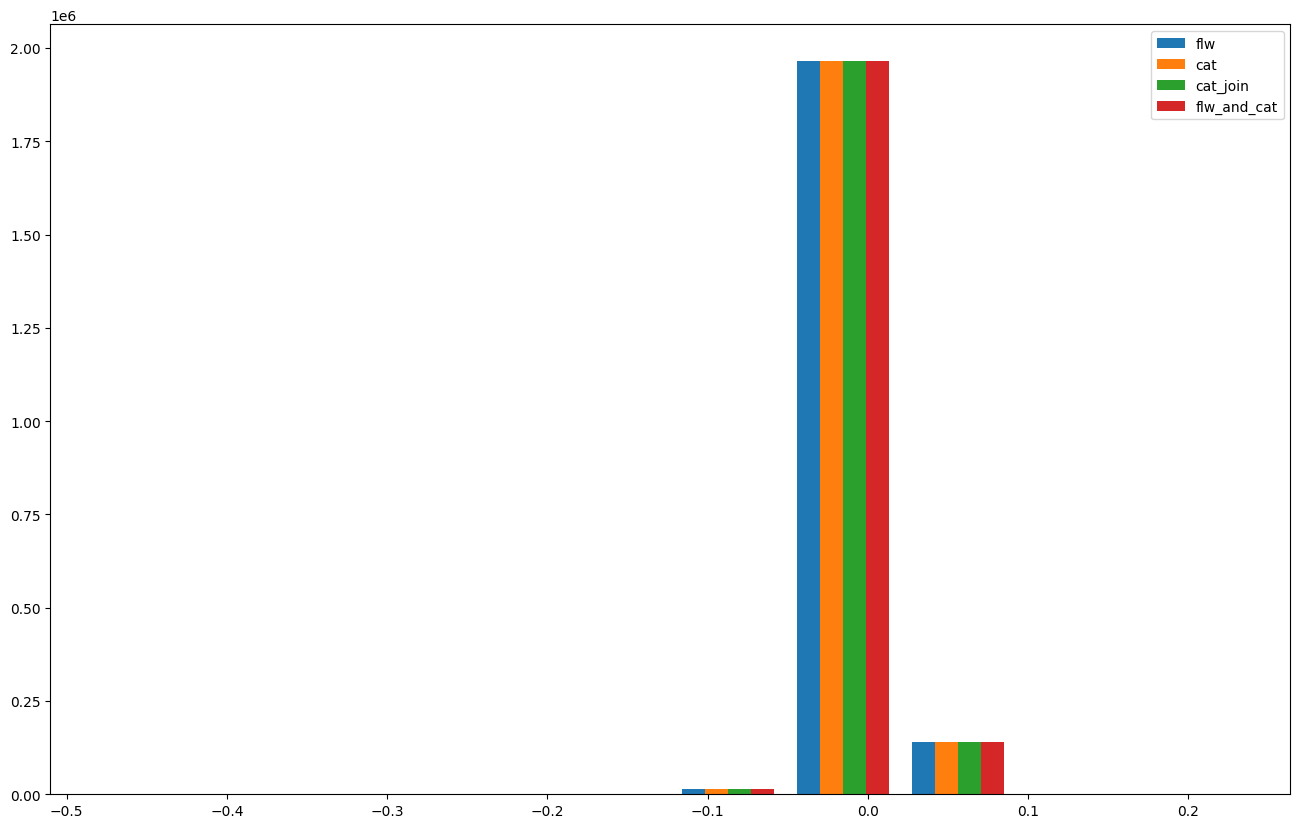

In [38]:
ind = 1
plt.figure(figsize=(16,10))
plt.hist([
    flattenmodel(model1),
    flattenmodel(model2),
    flattenmodel(model3),
    flattenmodel(model4)
    #model1.get_weights()[ind].flatten(),
    #model2.get_weights()[ind].flatten(),
    #model3.get_weights()[ind].flatten(),
    #model4.get_weights()[ind].flatten()
], label=['flw','cat','cat_join','flw_and_cat'])
plt.legend(loc='upper right')
#fig, axarr = plt.subplots(2,1, figsize=(16, 10))
#axarr[0].plot(model2.get_weights()[ind].flatten())
#axarr[1].plot(model3.get_weights()[ind].flatten())
#axarr[2].plot(model5.get_weights()[ind].flatten())

In [152]:
tts4, tts_raw4 = get_threshold_activation(model4, train_cat_join, all_layers)

IntProgress(value=0, max=63)

ds_size 2000 len(dataset) 63


In [153]:
act_freq4, raw_freq4 = get_activation_frequency(model4, train_cat_join, all_layers, tts4)

IntProgress(value=0, max=63)

ds_size 2000 len(dataset) 63


In [ ]:
ipos = 11
ipos2 = 1
dist = tts[ipos][ipos2]
#dist_val = tts[ipos][str(ipos2)+'_val']
med = np.mean(dist)#+(np.std(dist)*1)
#med_val = np.mean(dist_val)#+(np.std(dist_val)*1)
print('MAX', np.max(dist))
print('MED', med)
#print('MAX_val', np.max(dist_val))
#print('MED_val', med_val)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].hist(dist, bins=100)
ax[0].axvline(med, color='r', linewidth=1)
#ax[1].hist(dist_val, bins=100)
#ax[1].axvline(med_val, color='r', linewidth=1)
plt.plot()

In [75]:
activint1 = meansin3t1[0]
activoutt1 = get_activations(model3, meansout3t1)

C:\Users\joao\AppData\Local\Temp\ipykernel_8228\3056016646.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(activations)


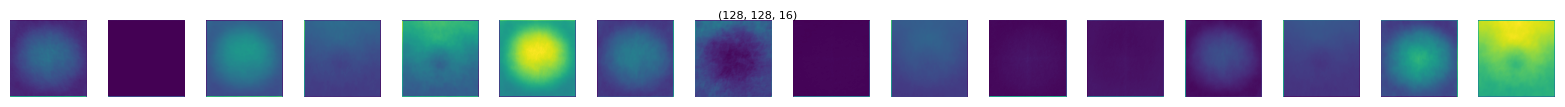

In [96]:
print_filters_3d(activoutt1[0])

MED 0.8771918


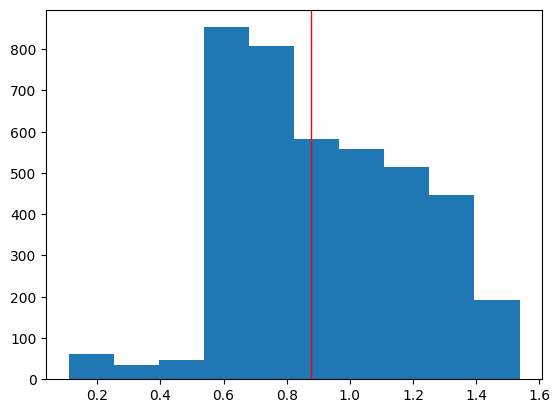

In [83]:
ipos = 10
dist = activoutt1[1][:,:,ipos].flatten()
med = np.median(dist)#-(dist.std()*1)
print('MED', med)
plt.hist(dist)
plt.axvline(med, color='r', linewidth=1)

In [58]:
#Interted dropout: output = output / drop_prob (pra manter a saida parecida quando o neuronio eh desativado) 
opti_fn2 = Memorizer(tf.keras.optimizers.Adam())
opti_fn2.integrateDNN = False
opti_fn2.memorize(activations)

model32 = tf.keras.models.clone_model(model3)
model32.set_weights(model3.get_weights())

C:\Users\joao\AppData\Local\Temp\ipykernel_1236\615933089.py:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.memory = np.array(memorization_indexes)


In [59]:
history32 = custom_training(model32, opti_fn2, loss_fn, train_cat_join, 10)

IntProgress(value=0, max=10)

In [48]:
print('OLD', custom_evaluate(model3, loss_fn, train_flw))
print('NEW', custom_evaluate(model32, loss_fn, train_cat_join))
print('NEW N OLD', custom_evaluate(model32, loss_fn, train_flw))

OLD (0.6987745, 0.729564)
NEW (1.9353923, 0.0)
NEW N OLD (1.8298082, 0.2527248)


In [47]:
for x, y in valid_flw.take(3):
    logits3 = model3(x[0:1,:,:,:], training=False)
    logits32 = model32(x[0:1,:,:,:], training=False)
    print(y[0].numpy(), np.argmax(logits3.numpy()[0]), np.argmax(logits32.numpy()[0]))
    print(logits3.numpy()[0])
    print(logits32.numpy()[0])

0 4 0
[ 2.9278872  3.1113522  3.150495  -1.6911155  3.6000946 -7.334844
 -6.942229 ]
[ 0.06345917 -0.5906073  -0.6147177  -0.03854511 -0.59762484 -0.31563407
 -0.4073079 ]
0 2 0
[ 2.6999142   1.4270815   6.114808    0.09021486  3.3811262  -8.903619
 -8.1092615 ]
[ 0.05957711 -0.8298311  -0.5963886   0.05631582 -0.6958753  -0.4560203
 -0.56298035]
1 1 0
[ 1.2786605   2.4608846   1.1547548   0.11033688  1.9698948  -6.469645
 -6.676598  ]
[ 0.04232191 -0.43255377 -0.50610024 -0.03800422 -0.6157082  -0.17206675
 -0.21978906]


In [60]:
means3t2, _ = get_mean_output(model32, train_cat_join, all_layers)
activations2 = get_activations(model32, means3t2)

IntProgress(value=0, max=63)

Mean calculated


C:\Users\joao\AppData\Local\Temp\ipykernel_1236\3056016646.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(activations)


In [92]:
new_weights_onlymax = []
new_weights_onlymin = []
for i in range(len(opti_fn2.memory)):
    new_weights_onlymax.append(model3.get_weights()[i] * (opti_fn2.memory[i] < 1).astype(float))
    new_weights_onlymin.append(model3.get_weights()[i] * opti_fn2.memory[i])

In [93]:
model33 = tf.keras.models.clone_model(model3)
model33.set_weights(new_weights_onlymax)
model34 = tf.keras.models.clone_model(model3)
model34.set_weights(new_weights_onlymin)

In [94]:
means33t1, _ = get_mean_output(model33, train_flw, all_layers)
activations3 = get_activations(model33, means33t1)
means33t2, _ = get_mean_output(model33, train_cat_join, all_layers)
activations4 = get_activations(model33, means33t2)

means34t1, _ = get_mean_output(model34, train_flw, all_layers)
activations5 = get_activations(model34, means34t1)
means34t2, _ = get_mean_output(model34, train_cat_join, all_layers)
activations6 = get_activations(model34, means34t2)

IntProgress(value=0, max=92)

Mean calculated


C:\Users\joao\AppData\Local\Temp\ipykernel_1236\3056016646.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(activations)


IntProgress(value=0, max=63)

Mean calculated


IntProgress(value=0, max=92)

Mean calculated


IntProgress(value=0, max=63)

Mean calculated


In [95]:
print('ONLYMAX', custom_evaluate(model33, loss_fn, train_flw))
print('ONLYMAX N NEW', custom_evaluate(model33, loss_fn, train_cat_join))

print('ONLYMIN', custom_evaluate(model34, loss_fn, train_flw))
print('ONLYMIN N NEW', custom_evaluate(model34, loss_fn, train_cat_join))

ONLYMAX (1.4657699, 0.35456404)
ONLYMAX N NEW (6.1927376, 0.0)
ONLYMIN (1.9112473, 0.29972753)
ONLYMIN N NEW (1.98636, 0.0)


In [ ]:
print_filters_3d(activations[0])
print_filters_3d(activations3[0]) # only max na T1
print_filters_3d(activations4[0]) # only max na T2
print_filters_3d(activations5[0]) # only min na T1
print_filters_3d(activations6[0]) # only min na T2
print_filters_3d(activations2[0]) # T2
#print_filters_1d(activations[4])

In [46]:
global_grads2 = global_grads.copy()
numpys = global_grads2[0].numpy()[:]
numpys[:,:,:,0] = np.zeros((3,3,3))
global_grads2[0] = tf.convert_to_tensor(numpys)

In [ ]:
fig, axarr = plt.subplots(2, 3, figsize=(10, 4))
mat1 = np.reshape(np.resize(meanst1[10][0], (144)), (12, 12))
axarr[0,0].imshow(model3.layers[10].get_weights()[0][:,:,0,0], cmap='gray')
axarr[0,1].imshow(model3.layers[10].get_weights()[0][:,:,1,0], cmap='gray')
axarr[0,2].imshow(model3.layers[10].get_weights()[0][:,:,2,0], cmap='gray')
axarr[1,0].imshow(global_grads[0][:,:,0,0], cmap='gray')
axarr[1,1].imshow(global_grads[0][:,:,1,0], cmap='gray')
axarr[1,2].imshow(global_grads[0][:,:,2,0], cmap='gray')

In [197]:
print(model.evaluate(train_flw))
print(model2.evaluate(train_cat_join))
print(model3.evaluate(train_flw))
print(model3.evaluate(train_cat_join))

92/92 [==============================] - 6s 62ms/step - loss: 0.6674 - accuracy: 0.7527
[0.6673895120620728, 0.7527247667312622]
63/63 [==============================] - 4s 60ms/step - loss: 0.5255 - accuracy: 0.7355
[0.5255239009857178, 0.7354999780654907]
92/92 [==============================] - 6s 63ms/step - loss: 17.6026 - accuracy: 0.0000e+00
[17.60260772705078, 0.0]
63/63 [==============================] - 4s 59ms/step - loss: 0.5974 - accuracy: 0.6825
[0.597402811050415, 0.6825000047683716]


In [ ]:
custom_evaluate(model3, loss_fn, valid_cat_join)

# Optimizer

In [48]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(epoch)
        print(self.model)
        

class Memorizer(tf.keras.optimizers.Optimizer):
    def __init__(self, optimizer, **kwargs):
        self.optimizer = optimizer
        super().__init__('Memorizer')
        
        self.memory = None
        self.memory_index = 0

        self.integrateCNN = False
        self.thresholdCNN = 0.5

        self.integrateDNN = True
        self.halfIntegrateDNN = False
        self.thresholdDNN = 0.7

    def memorize(self, layer_activations):
        memorization_indexes = []

        for layer in layer_activations:
            #layer = layer_activations[l]

            mem_index = None

            #if layer is None:
            #    mem_index = 1.0
                
            #elif
            if len(layer.shape) == 1: #dnn
                percented = (layer / layer.max()) #sum

                if self.integrateDNN: # integration
                    mem_index = percented.copy()
                    mem_index[mem_index < 0] = 0
                    mem_index = 1 - mem_index

                else: # segregation
                    mem_index = layer.copy()

                    mem_index[percented < self.thresholdDNN] = 0
                    if not self.halfIntegrateDNN:
                        mem_index[percented >= self.thresholdDNN] = 1
                        
            else: # cnn
                total = layer.reshape(-1, layer.shape[-1]).sum(axis=0)

                if self.integrateCNN: # integration
                    mem_index = (total / total.max())
                    mem_index[mem_index < 0] = 0
                    mem_index = 1 - mem_index

                else: # segregation
                    threshold = np.percentile(total, self.thresholdCNN*100)
                    filter_indexes = total < threshold
                    mem_index = np.array([index * 1.0 for index in filter_indexes])
            
            memorization_indexes.append(mem_index)
            memorization_indexes.append(mem_index) # one for bias

        self.memory = np.array(memorization_indexes)

    def _crop_grad(self, gradients):
        if self.memory is None:
            return gradients
        else:
            #print(gradients.shape, self.memory_index)
            new_grad = gradients.numpy() * self.memory[self.memory_index]
            self.memory_index = (self.memory_index + 1) % len(self.memory)
            return tf.convert_to_tensor(new_grad, dtype=np.float32)
            
            #new_grads = []
            #for i in range(len(gradients)):
                #new_grad = gradients[i].numpy() * self.memory[i]
                #new_grads.append(new_grad)
            #return tf.convert_to_tensor(new_grads)


    """
    Keras mandatory methods for Optimizer
    """
    def build(self, var_list):
        super().build(var_list)
        self.optimizer.build(var_list)
        if hasattr(self, "_built") and self._built:
            return
        self._built = True

    def update_step(self, gradient, variable):
        #self.optimizer().update_step(self._crop_grad(gradient), variable)
        #print('111')
        #print(gradient)
        self.optimizer.update_step(self._crop_grad(gradient), variable)
        
    @property
    def _learning_rate(self):
        return self.optimizer._learning_rate
    
    @_learning_rate.setter
    def _learning_rate(self, value):
        self.optimizer._learning_rate = value

    def get_config(self):
        config = super().get_config()
        config.update({
            "memory": self.memory,
            "optimizer": self.optimizer.get_config()
        })
        return config

In [ ]:
%%time
model6 = generate_model(total_label)
opti_fn = Memorizer(tf.keras.optimizers.Adam())
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
history6 = custom_training(model6, opti_fn, loss_fn, train_flw, 10)

In [ ]:
#Interted dropout: output = output / drop_prob (pra manter a saida parecida quando o neuronio eh desativado) 
opti_fn2 = Memorizer(tf.keras.optimizers.Adam())
opti_fn2.integrateDNN = False
opti_fn2.memorize(activations)

model32 = tf.keras.models.clone_model(model6)
model32.set_weights(model6.get_weights())

In [ ]:
print(model.evaluate(train_flw))
print(model2.evaluate(train_cat_join))
print(model3.evaluate(train_flw))
print(model3.evaluate(train_cat_join))

# Optimizer native

In [141]:
epochs=1#10
model4 = generate_model(total_label)

opti_fn = Memorizer(tf.keras.optimizers.Adam())
model4.compile(optimizer=opti_fn, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [142]:
%%time
historyt41 = model4.fit(train_flw, validation_data=valid_flw, epochs=epochs, verbose=1) # callbacks=[CustomCallback()]

g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
g
92/92 [==============================] - 24s 248ms/step - loss: 1.3014 - accuracy: 0.4363 - val_loss: 1.0588 - val_accuracy: 0.5995
CPU times: total: 1min 21s
Wall time: 24.3 s


In [ ]:
print(model4.evaluate(train_flw))
model4.evaluate(train_cat_join)

In [ ]:
model.evaluate(train_flw)

In [ ]:
means4t1, _ = get_mean_output(model4, train_flw, all_layers)

In [ ]:
activations2 = []
for i in range(len(model4.layers)):
    if i in all_layers:
        activations2.append(means4t1[i][0].numpy())
    else:
        activations2.append(None)
activations2 = np.array(activations2)

In [143]:
model4.optimizer.memorize(activations2)

C:\Users\joao\AppData\Local\Temp\ipykernel_2456\137016010.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.memory = np.array(memorization_indexes)


In [144]:
historyt42 = model4.fit(train_cat_join, validation_data=valid_cat_join, epochs=epochs, verbose=1) # callbacks=[CustomCallback()]

63/63 [==============================] - 16s 258ms/step - loss: 1.4125 - accuracy: 0.3870 - val_loss: 0.6866 - val_accuracy: 0.5590


In [ ]:
print(model4.evaluate(train_flw))
model4.evaluate(train_cat_join)

# Regularizer

In [41]:
class MemoryRegularizer(tf.keras.regularizers.Regularizer):

    def __init__(self):
        self.task = 0
        self.memory = None
        
    def remember(activations):
        self.memory = activations

    def __call__(self, x):
        if self.memory:
            return self.memory * x
        return 0.0

    def get_config(self):
        return {'activations': self.activations}

In [44]:
#%%time
model_r = generate_model(total_label, MemoryRegularizer)
#opti_fn_r = tf.keras.optimizers.Adam()
#loss_fn_r = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#history_r = custom_training(model_r, opti_fn4, loss_fn4, train_flw, 10)
#custom_evaluate(model_r, loss_fn_r, train_flw)

In [46]:
model_r.layers[2]

# Loss based

In [17]:
%%time
model1 = generate_model(total_label)
opti_fn1 = tf.keras.optimizers.Adam()
loss_fn1 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
history1 = custom_training(model1, opti_fn1, loss_fn1, train_flw, 10)
custom_evaluate(model1, loss_fn1, train_flw)

IntProgress(value=0, max=10)

CPU times: total: 16min 14s
Wall time: 5min 50s


(0.6220682, 0.7632834)

In [25]:
def loss_importance(model, loss, ds_train):    
    f = IntProgress(min=0, max=len(ds_train))
    display(f)
    
    avg_delta = None
    max_delta = None
    min_delta = None
    
    for x, y in ds_train:
        with tf.GradientTape(persistent=True) as tape:
            logits = model(x, training=True)
            loss_value = loss(y, logits)

        grads = tape.gradient(loss_value, model.trainable_weights)
        del tape
        
        #print(grads[1][0])
        #avg_delta = np.absolute(grads) if avg_delta is None else avg_delta + np.absolute(grads)
        #max_delta = grads.copy() if max_delta is None else np.max((max_delta, grads), axis=0)
        #min_delta = grads.copy() if min_delta is None else np.min((min_delta, grads), axis=0)
        if avg_delta is None:
            avg_delta = np.absolute(grads)
            max_delta = grads.copy()
            min_delta = grads.copy()
        else:
            for i in range(len(grads)):
                avg_delta[i] = avg_delta[i] + np.absolute(grads[i])
                max_delta[i] = np.max((max_delta[i], grads[i]), axis=0)
                min_delta[i] = np.min((min_delta[i], grads[i]), axis=0)
        
        f.value += 1
    
    avg_delta = avg_delta / len(ds_train)
    
    diff_delta = np.absolute(np.absolute(max_delta) - np.absolute(min_delta))
    
    variation_delta = avg_delta + diff_delta
    
    max_scale = 0
    for i in range(len(variation_delta)):
        max_scale = np.max((max_scale, np.max(variation_delta[i])))
    print('max_scale', max_scale)
        
    importance = 1 - (variation_delta / max_scale)
    
    return importance #min_delta, avg_delta, max_delta, diff_delta, variation_delta, importance

In [25]:
loss_efene = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
y_true = [2]
y_pred = [[11, 5., 0]]
loss_efene(y_true, y_pred).numpy()

11.002492

In [118]:
mae = tf.keras.losses.MeanAbsoluteError()
y_true = [[100.]]
y_pred = [[102.]]
mae(y_true, y_pred)#.numpy()

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

In [26]:
importance1 = loss_importance(model1, loss_fn1, train_flw)

IntProgress(value=0, max=92)

C:\Users\joao\AppData\Local\Temp\ipykernel_1980\1526743982.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_delta = np.absolute(grads)


max_scale 2.0064404010772705


C:\Users\joao\AppData\Local\Temp\ipykernel_1980\1526743982.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  diff_delta = np.absolute(np.absolute(max_delta) - np.absolute(min_delta))


In [ ]:
mind[1] # min

In [ ]:
avgd[1] # avg

In [ ]:
maxd[1] # max

In [ ]:
difd[1] # diff

In [ ]:
vard[1] # variational

In [ ]:
importance[1] # scaled

In [27]:
def discharge2(threshold, impd, mind, maxd):
    grads = []
    for l in range(len(impd)):
        mask = (impd[l] >= threshold).numpy().astype(float)
        lim_min = np.ones(impd[l].shape) * -0.01
        lim_max = np.ones(impd[l].shape) * 0.01
        delta = random.uniform(lim_min, lim_max)#(mind[l], maxd[l])
        grad = (impd[l].numpy() * delta * mask).astype('float32')
        grads.append(grad)
    return grads

def discharge(threshold, importance, new_w, old_w):
    grads = []
    for l in range(len(importance)):
        mask = (importance[l] >= threshold).numpy().astype(float)
        diff = old_w[l] - new_w[l]
        updates = np.zeros(importance[l].shape)
        updates[diff > 0] = -0.0001 # yes its inversed
        updates[diff < 0] = 0.0001
        grad = (updates * mask).astype('float32')
        #if l == 1:
        #    print(diff)
        #    print(grad)
        #    print('--')
        grads.append(grad)
    return grads
        
def stimulate(epochs, model, optimizer, importance, old_w):
    #old_w = model.trainable_variables.copy()
    for _ in range(epochs):
        threshold = np.round(random.triangular(0.5, 0.95, 0.8), decimals=3)
        grads = discharge(threshold, importance, model.trainable_variables, old_w)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [21]:
custom_evaluate(model1, loss_fn1, train_flw)

(0.6216824, 0.7632834)

In [22]:
old_w = model1.trainable_variables.copy()

In [28]:
# SAME RESULTS

model1new = tf.keras.models.clone_model(model1)
model1new.set_weights(model1.get_weights())
# opti_fn1
# tf.keras.optimizers.Adam()
# tf.keras.optimizers.legacy.Adam()
stimulate(10, model1new, tf.keras.optimizers.Adam(), importance1, old_w)
custom_evaluate(model1new, loss_fn1, train_flw)

(0.62189883, 0.7632834)

In [24]:
model2 = tf.keras.models.clone_model(model1)
model2.set_weights(model1.get_weights())
custom_training(model2, tf.keras.optimizers.Adam(), loss_fn1, train_cat_join, 10)
print('flw', custom_evaluate(model2, loss_fn1, train_flw))
print('cat', custom_evaluate(model2, loss_fn1, train_cat_join))

IntProgress(value=0, max=10)

flw (19.11871, 0.0)
cat (0.5013711, 0.7485)


In [29]:
importance2 = loss_importance(model2, loss_fn1, train_cat_join)

IntProgress(value=0, max=63)

C:\Users\joao\AppData\Local\Temp\ipykernel_1980\1526743982.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  avg_delta = np.absolute(grads)


max_scale 1.18307626247406


C:\Users\joao\AppData\Local\Temp\ipykernel_1980\1526743982.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  diff_delta = np.absolute(np.absolute(max_delta) - np.absolute(min_delta))


In [30]:
importance1[1]

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([0.7982094 , 0.5684382 , 0.5876296 , 0.        , 0.6575122 ,
       0.73444146, 0.8902676 , 0.7825985 , 0.6086205 , 0.5795736 ,
       0.458929  , 0.524657  , 0.50740004, 0.4271112 , 0.77260286,
       0.88055027], dtype=float32)>

In [31]:
importance2[1]

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([0.8946046 , 0.70417523, 0.62469333, 0.7584925 , 0.14398938,
       0.11026937, 0.45752364, 0.        , 0.52691793, 0.4825034 ,
       0.9732699 , 0.53733855, 0.99174935, 0.8883437 , 0.8022505 ,
       0.84619844], dtype=float32)>

In [32]:
model1.trainable_variables[1]

<tf.Variable 'conv2d/bias:0' shape=(16,) dtype=float32, numpy=
array([-0.07158613, -0.01615172, -0.00872199, -0.00055972, -0.00314442,
       -0.01612883,  0.00296274,  0.0121996 , -0.00262418,  0.05466822,
        0.01631035, -0.01899122, -0.02866549,  0.00467502, -0.03369959,
       -0.00027158], dtype=float32)>

In [33]:
model2.trainable_variables[1]

<tf.Variable 'conv2d/bias:0' shape=(16,) dtype=float32, numpy=
array([-0.07840497, -0.00871312, -0.00700255,  0.00069498, -0.00267906,
       -0.02799025,  0.06367556,  0.01490808,  0.00336679,  0.07673761,
       -0.01277499, -0.0152435 , -0.04155723,  0.01402659, -0.01268583,
       -0.00079985], dtype=float32)>

In [82]:
model2new = tf.keras.models.clone_model(model2)
model2new.set_weights(model2.get_weights())

stimulate(9, model2new, tf.keras.optimizers.Adam(), importance1, old_w)

print('flw', custom_evaluate(model2new, loss_fn1, train_flw))
print('cat', custom_evaluate(model2new, loss_fn1, train_cat_join))

flw (2.0199885, 0.34673023)
cat (1.3141752, 0.5665)


In [83]:
print(old_w[1])
print(model2.trainable_variables[1])
print(model2new.trainable_variables[1])

<tf.Variable 'conv2d/bias:0' shape=(16,) dtype=float32, numpy=
array([ 0.068904  ,  0.00673107, -0.01880267,  0.01013466, -0.00179283,
        0.01066628, -0.0373735 , -0.02149796,  0.02789856, -0.00170739,
        0.00513786, -0.04882817, -0.03794092, -0.00816449,  0.01612929,
        0.00809575], dtype=float32)>
<tf.Variable 'conv2d/bias:0' shape=(16,) dtype=float32, numpy=
array([ 0.11722769, -0.0070553 , -0.02762494,  0.01609288,  0.00579322,
       -0.00664733, -0.05463636, -0.01717867,  0.06345662,  0.00428266,
       -0.00348215, -0.02017258, -0.04476164, -0.00726361,  0.02486545,
       -0.00172491], dtype=float32)>
<tf.Variable 'conv2d/bias:0' shape=(16,) dtype=float32, numpy=
array([ 0.10837387,  0.00179851, -0.02762494,  0.01609288, -0.00273752,
        0.00134171, -0.047159  , -0.02312639,  0.05546759, -0.00361004,
        0.0026255 , -0.02902639, -0.03711501, -0.00726361,  0.01977605,
        0.00409108], dtype=float32)>
